In [1]:
import veritas
from veritas import Domain
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from matplotlib.patches import Rectangle
import matplotlib as mpl

In [2]:
def sqdist1(a, b, a0, b0):
    return np.sqrt((a-a0)**2 + (b-b0)**2)
def mesh(a, b):
    return np.fliplr(np.meshgrid(a, b, indexing="xy"))
def label(a, b, c):
    label = c.copy()
    label += a + b
    label[((c > 3) & (a < -2)) | ((c > 7) & (b > -2))] = 10
    return label

In [3]:
a0 = -3
b0 = 2
a = np.linspace(-5, 5, 200)
b = np.linspace(-5, 5, 200)
extent = [min(a), max(a), min(b), max(b)]

agrid, bgrid = mesh(a, b)

c = sqdist1(a, b, a0, b0)
cgrid = sqdist1(agrid, bgrid, a0, b0)

y = label(a, b, c)

X = np.vstack([agrid.ravel(), bgrid.ravel(), cgrid.ravel()]).T
Y = label(agrid, bgrid, cgrid).ravel()

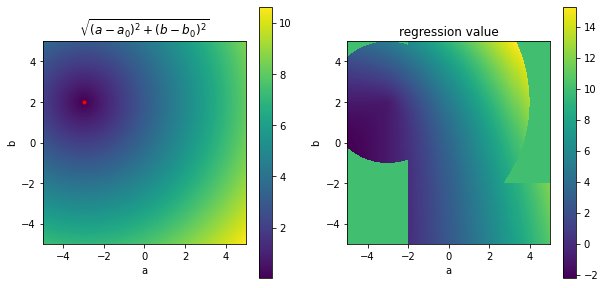

In [4]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))
im = ax.imshow(cgrid, extent=extent)
ax.plot([a0], [b0], ".", c="red")
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_title("$\sqrt{{(a-a_0)}^2 + {(b-b_0)}^2}$")
fig.colorbar(im, ax=ax)

im=ax2.imshow(label(agrid, bgrid, cgrid), extent=extent, interpolation="none")
ax2.set_xlabel("a")
ax2.set_ylabel("b")
ax2.set_title("regression value")
fig.colorbar(im, ax=ax2)
plt.show()

In [5]:
dtrain = lgb.Dataset(X, Y)
params = {"objective": "l2", "boosting": "gbdt", "learning_rate":1.0, "max_depth":2}
bst = lgb.train(params, dtrain, num_boost_round=1)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 3
[LightGBM] [Info] Start training from score 6.117463


In [6]:
Ypred = bst.predict(X)

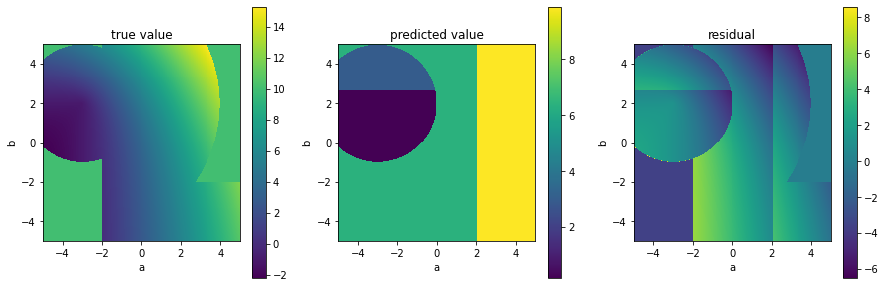

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

im=ax1.imshow(Y.reshape(cgrid.shape), extent=extent, interpolation="none")
ax1.set_xlabel("a")
ax1.set_ylabel("b")
ax1.set_title("true value")
fig.colorbar(im, ax=ax1)

im=ax2.imshow(Ypred.reshape(cgrid.shape), extent=extent, interpolation="none")
ax2.set_xlabel("a")
ax2.set_ylabel("b")
ax2.set_title("predicted value")
fig.colorbar(im, ax=ax2)

im=ax3.imshow((Ypred-Y).reshape(cgrid.shape), extent=extent, interpolation="none")
ax3.set_xlabel("a")
ax3.set_ylabel("b")
ax3.set_title("residual")
fig.colorbar(im, ax=ax3)
plt.show()

In [8]:
at = veritas.addtree_from_lgb_model(bst)

In [9]:
Ypred2 = at.eval(X)

In [10]:
np.argmax(Ypred-Ypred2)

9400

In [11]:
i=np.argmax(Ypred-Ypred2); X[i,:], Y[i], Ypred[i], Ypred2[i]

(array([-5.        ,  2.63819095,  2.09935411]),
 -0.26245493151515786,
 0.15504516694528991,
 0.15504517)

In [12]:
if np.max(Ypred-Ypred2) > 1e-5:
    print("WARNING: AddTree not the same")

In [13]:
s = veritas.Search.max_output(at)
#s.prune([Domain(), Domain(), Domain(0,0)])
s.add_sqdist1_constraint(0, 1, 2, a0, b0)
s.steps(1000)

notify 1: Dom(R) -> Dom(<=2.66332)
notify_flatbox_change_ caret=1, feat_id=1, Dom(<=2.66332), grp=-1
Dom(R) Dom(<=2.66332) 0 0 inf inf -> 0 inf
notify_flatbox_change_ caret=1, feat_id=2, Dom(>=0), grp=0
notify 2: Dom(R) -> Dom(0,2.99159)
notify_flatbox_change_ caret=2, feat_id=2, Dom(0,2.99159), grp=-1
(1) Dom(R), Dom(<=2.66332), Dom(0,2.99159) -3, -0.00841284; -3, -0.00841284
(2) Dom(R), Dom(<=2.66332), Dom(0,2.99159) -5.99159, -3; -0.991587, 2
 - 0: Dom(-5.99159,-3) (old Dom(R)) -> Dom(-5.99159,-3)
 - 1: Dom(-0.991587,2) (old Dom(<=2.66332)) -> Dom(-0.991587,2)
notify_flatbox_change_ caret=2, feat_id=1, Dom(-0.991587,2), grp=0
 - 1: Dom(2,4.99159) (old Dom(<=2.66332)) -> Dom(2,2.66332)
notify_flatbox_change_ caret=2, feat_id=1, Dom(2,4.99159), grp=0
notify_flatbox_change_ caret=2, feat_id=0, Dom(-5.99159,-3), grp=0
 - 0: Dom(-3,-0.00841284) (old Dom(R)) -> Dom(-3,-0.00841284)
 - 1: Dom(-0.991587,2) (old Dom(2,2.66332)) -> Dom(2,2)
notify_flatbox_change_ caret=2, feat_id=1, Dom(-0.991

<StopReason.NO_MORE_OPEN: 1>

In [14]:
s.num_solutions()

13

{0: Dom(>=2.0603), 1: Dom(>=2), 2: Dom(>=5.0603)} 9.891098976135254 Rectangle(xy=(2.0603, 2), width=2.9397, height=3, angle=0)
{0: Dom(>=2.0603), 1: Dom(>=2), 2: Dom(>=5.0603)} 9.891098976135254 Rectangle(xy=(2.0603, 2), width=2.9397, height=3, angle=0)
{0: Dom(-3,2.0603), 1: Dom(>=2), 2: Dom(>=2.99159)} 6.362396240234375 Rectangle(xy=(-3, 2), width=5.0603, height=3, angle=0)
{0: Dom(-3,2.0603), 1: Dom(>=2), 2: Dom(>=2.99159)} 6.362396240234375 Rectangle(xy=(-3, 2), width=5.0603, height=3, angle=0)
{0: Dom(<=-3), 1: Dom(>=2), 2: Dom(>=2.99159)} 6.362396240234375 Rectangle(xy=(-5, 2), width=2, height=3, angle=0)
{0: Dom(<=-3), 1: Dom(<=2), 2: Dom(>=2.99159)} 6.362396240234375 Rectangle(xy=(-5, -5), width=2, height=7, angle=0)
{0: Dom(-3,2.0603), 1: Dom(2,2), 2: Dom(>=2.99159)} 6.362396240234375 Rectangle(xy=(-3, 2), width=5.0603, height=0, angle=0)
{0: Dom(-3,-0.0828772), 1: Dom(2.66332,4.99159), 2: Dom(0.663316,2.99159)} 3.0028011798858643 Rectangle(xy=(-3, 2.66332), width=2.91712, hei

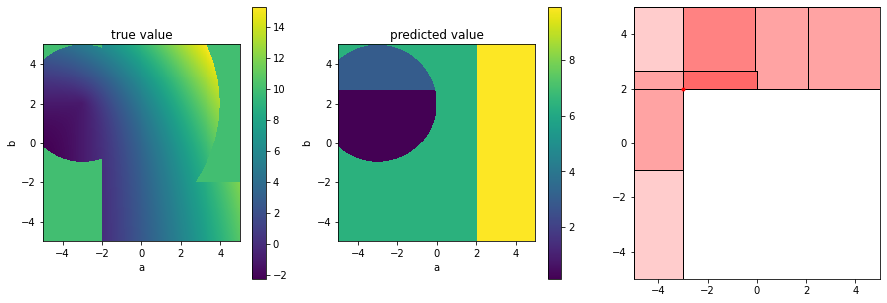

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

im=ax1.imshow(Y.reshape(cgrid.shape), extent=extent, interpolation="none")
ax1.set_xlabel("a")
ax1.set_ylabel("b")
ax1.set_title("true value")
fig.colorbar(im, ax=ax1)

im=ax2.imshow(Ypred.reshape(cgrid.shape), extent=extent, interpolation="none")
ax2.set_xlabel("a")
ax2.set_ylabel("b")
ax2.set_title("predicted value")
fig.colorbar(im, ax=ax2)

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=min(Y), vmax=max(Y))

for i in range(s.num_solutions()):
    sol = s.get_solution(i)
    box = sol.box()
    xlo = max(extent[0], box[0].lo if 0 in box else -np.inf)
    xhi = min(extent[1], box[0].hi if 0 in box else np.inf)
    ylo = max(extent[2], box[1].lo if 1 in box else -np.inf)
    yhi = min(extent[3], box[1].hi if 1 in box else np.inf)
    
    #r = Rectangle((xlo, ylo), xhi-xlo, yhi-ylo, fill=True, facecolor=cmap(norm((sol.output))), alpha=0.5)
    r = Rectangle((xlo, ylo), xhi-xlo, yhi-ylo, fill=True, facecolor=(1,0,0,.2))
    print(box, sol.output, r)
    ax3.add_patch(r)
    r = Rectangle((xlo, ylo), xhi-xlo, yhi-ylo, ls="-", lw=1, fill=False)
    ax3.add_patch(r)

ax3.set_xlim(extent[0:2])
ax3.set_ylim(extent[2:4])
ax3.plot([a0], [b0], ".", c="red")
plt.show()

In [ ]:
#### extent

In [16]:
at.get_splits()

{1: [2.663316249847412], 0: [2.0603013038635254], 2: [2.9915874004364014]}

In [17]:
print(at[0])

Node(id=0, split=[F2 < 2.99159], sz=7, left=1, right=2)
├─ Node(id=1, split=[F1 < 2.66332], sz=3, left=3, right=4)
│  ├─ Leaf(id=3, sz=1, value=0.155045)
│  └─ Leaf(id=4, sz=1, value=3.0028)
├─ Node(id=2, split=[F0 < 2.0603], sz=3, left=5, right=6)
│  ├─ Leaf(id=5, sz=1, value=6.3624)
│  └─ Leaf(id=6, sz=1, value=9.8911)



In [18]:
print(len(at))


1
